# NASA TESS Objects of Interest (TOI) Analysis
## Exoplanet Classification Pipeline

This notebook analyzes the TESS Objects of Interest (TOI) dataset as part of the comprehensive NASA Space Apps challenge solution. Following the successful methodology established with the Kepler dataset, we'll implement a systematic approach for:

1. **Data Exploration & Analysis (EDA)**
2. **Feature Engineering & Preprocessing**
3. **Model Training & Evaluation**
4. **Performance Analysis**

### Mission Context
The Transiting Exoplanet Survey Satellite (TESS) is NASA's follow-up mission to Kepler, designed to survey the entire sky for exoplanets. TOI (TESS Objects of Interest) represents candidate planets identified by the TESS mission that require further validation.

### Dataset Overview
- **Source**: TESS Mission Data
- **File**: `TOI_2025.09.26_02.41.12.csv`
- **Mission Type**: Space-based photometric survey
- **Detection Method**: Transit photometry
- **Target**: Multi-class exoplanet classification

In [22]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print("🚀 Starting TOI Dataset Analysis Pipeline")

✅ Libraries imported successfully
🚀 Starting TOI Dataset Analysis Pipeline


In [2]:
# Load TOI dataset - skip comment lines that start with #
toi_data = pd.read_csv('TOI_2025.09.26_02.41.12.csv', comment='#', low_memory=False)

print("📊 TOI Dataset Loaded Successfully")
print(f"Dataset Shape: {toi_data.shape}")
print(f"Columns: {len(toi_data.columns)}")
print(f"Rows: {len(toi_data)}")

# Display first few rows
print("\n🔍 First 5 rows of the dataset:")
toi_data.head()

📊 TOI Dataset Loaded Successfully
Dataset Shape: (7699, 66)
Columns: 66
Rows: 7699

🔍 First 5 rows of the dataset:


,loc_rowid,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,4,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,5,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


## 1. Dataset Overview & Initial Exploration

In [3]:
# Basic dataset information
print("📈 TOI Dataset Information:")
print("=" * 50)
print(f"Shape: {toi_data.shape}")
print(f"Memory usage: {toi_data.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Duplicate rows: {toi_data.duplicated().sum()}")

print("\n📊 Column Information:")
print(toi_data.info())

print("\n🎯 Data Types Summary:")
print(toi_data.dtypes.value_counts())

📈 TOI Dataset Information:
Shape: (7699, 66)
Memory usage: 3.88 MB
Duplicate rows: 0

📊 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7699 entries, 0 to 7698
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loc_rowid        7699 non-null   int64  
 1   toi              7699 non-null   float64
 2   tid              7699 non-null   int64  
 3   tfopwg_disp      7699 non-null   object 
 4   rastr            7699 non-null   object 
 5   ra               7699 non-null   float64
 6   decstr           7699 non-null   object 
 7   dec              7699 non-null   float64
 8   st_pmra          7565 non-null   float64
 9   st_pmraerr1      7565 non-null   float64
 10  st_pmraerr2      7565 non-null   float64
 11  st_pmralim       7565 non-null   float64
 12  st_pmdec         7565 non-null   float64
 13  st_pmdecerr1     7565 non-null   float64
 14  st_pmdecerr2     7565 non-null   float64
 15

🔍 Missing Data Analysis:
             Column  Missing_Count  Missing_Percentage
43        pl_eqtlim           7699          100.000000
42       pl_eqterr2           7699          100.000000
41       pl_eqterr1           7699          100.000000
39      pl_insollim           7699          100.000000
38     pl_insolerr2           7699          100.000000
37     pl_insolerr1           7699          100.000000
58      st_loggerr2           2270           29.484349
57      st_loggerr1           2270           29.484349
62       st_raderr2           1962           25.483829
61       st_raderr1           1962           25.483829
33      pl_radeerr1           1623           21.080660
34      pl_radeerr2           1623           21.080660
56          st_logg            856           11.118327
49      st_disterr1            707            9.183011
50      st_disterr2            707            9.183011
60           st_rad            507            6.585271
32          pl_rade            506      

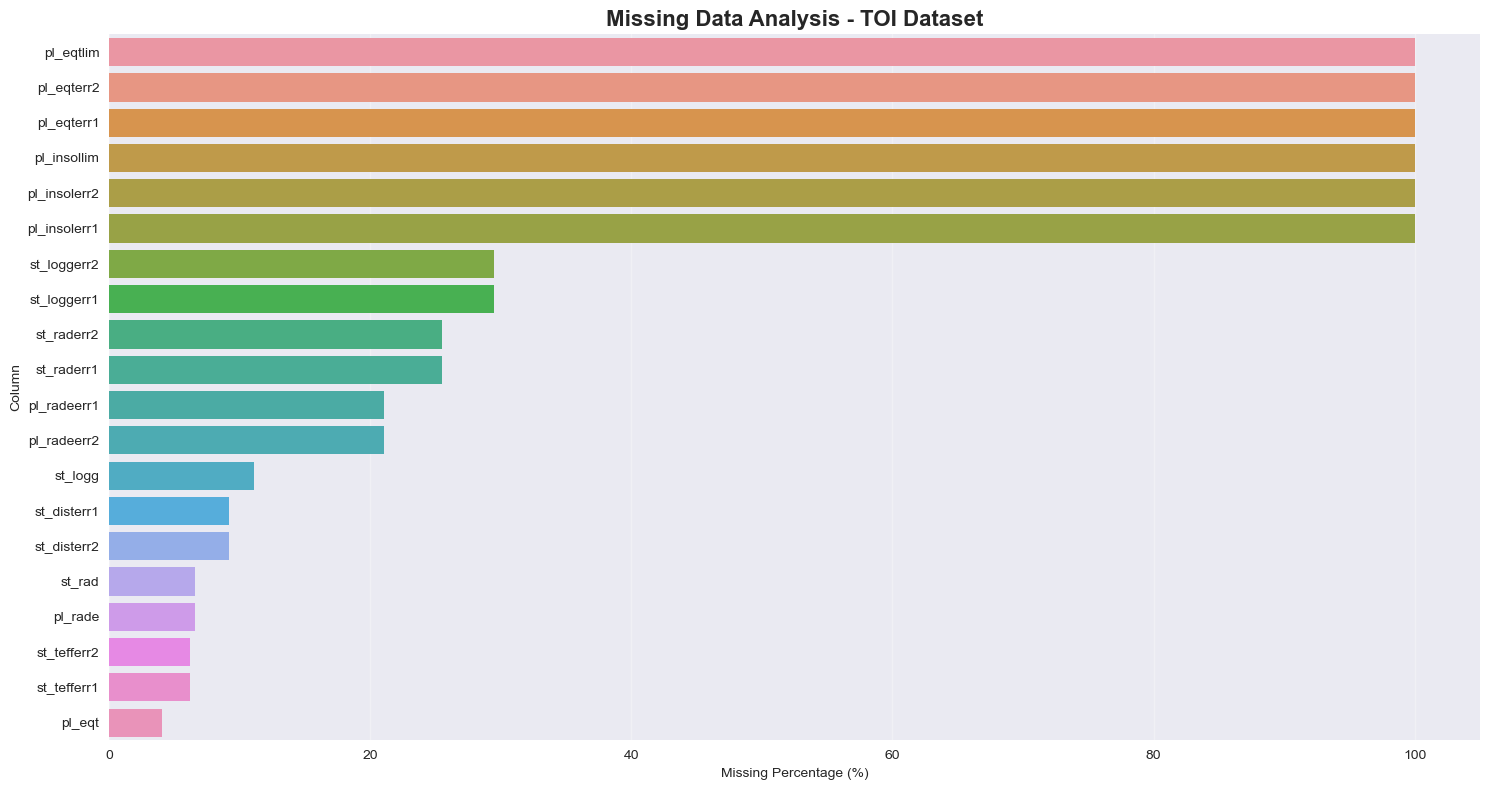

In [4]:
# Missing data analysis
print("🔍 Missing Data Analysis:")
print("=" * 50)
missing_data = toi_data.isnull().sum()
missing_percent = (missing_data / len(toi_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing data
plt.figure(figsize=(15, 8))
missing_data_viz = missing_df[missing_df['Missing_Count'] > 0].head(20)
sns.barplot(data=missing_data_viz, x='Missing_Percentage', y='Column')
plt.title('Missing Data Analysis - TOI Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Missing Percentage (%)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Target variable analysis
# Identify potential target columns
target_candidates = [col for col in toi_data.columns if any(keyword in col.lower() 
                    for keyword in ['disp', 'planet', 'candidate', 'confirmed', 'status', 'class'])]

print("🎯 Potential Target Variables:")
print("=" * 50)
for col in target_candidates:
    print(f"\n📊 {col}:")
    if toi_data[col].dtype == 'object':
        print(toi_data[col].value_counts())
    else:
        print(f"Unique values: {toi_data[col].nunique()}")
        print(f"Range: {toi_data[col].min()} to {toi_data[col].max()}")

# Display column names to understand the dataset structure
print(f"\n📋 All Column Names ({len(toi_data.columns)} total):")
print("=" * 50)
for i, col in enumerate(toi_data.columns, 1):
    print(f"{i:2d}. {col}")
    if i % 5 == 0:
        print()

🎯 Potential Target Variables:

📊 tfopwg_disp:
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: tfopwg_disp, dtype: int64

📋 All Column Names (66 total):
 1. loc_rowid
 2. toi
 3. tid
 4. tfopwg_disp
 5. rastr

 6. ra
 7. decstr
 8. dec
 9. st_pmra
10. st_pmraerr1

11. st_pmraerr2
12. st_pmralim
13. st_pmdec
14. st_pmdecerr1
15. st_pmdecerr2

16. st_pmdeclim
17. pl_tranmid
18. pl_tranmiderr1
19. pl_tranmiderr2
20. pl_tranmidlim

21. pl_orbper
22. pl_orbpererr1
23. pl_orbpererr2
24. pl_orbperlim
25. pl_trandurh

26. pl_trandurherr1
27. pl_trandurherr2
28. pl_trandurhlim
29. pl_trandep
30. pl_trandeperr1

31. pl_trandeperr2
32. pl_trandeplim
33. pl_rade
34. pl_radeerr1
35. pl_radeerr2

36. pl_radelim
37. pl_insol
38. pl_insolerr1
39. pl_insolerr2
40. pl_insollim

41. pl_eqt
42. pl_eqterr1
43. pl_eqterr2
44. pl_eqtlim
45. st_tmag

46. st_tmagerr1
47. st_tmagerr2
48. st_tmaglim
49. st_dist
50. st_disterr1

51. st_disterr2
52. st_distlim
53. st_teff
54. st_teffer

## 2. Exploratory Data Analysis (EDA)

📊 Numerical Features (61 total):
📈 Statistical Summary:
         loc_rowid          toi           tid           ra          dec  \
count  7699.000000  7699.000000  7.699000e+03  7699.000000  7699.000000   
mean   3850.000000  3747.086607  2.454749e+08   179.761440     1.192194   
std    2222.654194  2151.210112  1.617218e+08   103.694038    47.450357   
min       1.000000   101.010000  2.876000e+03     0.084680   -89.471513   
25%    1925.500000  1860.510000  1.310589e+08    96.067789   -43.340501   
50%    3850.000000  3734.010000  2.498624e+08   161.156925     4.779380   
75%    5774.500000  5612.510000  3.540319e+08   282.921899    43.832124   
max    7699.000000  7505.010000  2.041563e+09   359.941195    89.086923   

           st_pmra  st_pmraerr1  st_pmraerr2  st_pmralim     st_pmdec  ...  \
count  7565.000000  7565.000000  7565.000000      7565.0  7565.000000  ...   
mean     -0.576017     0.228825    -0.228825         0.0    -9.180086  ...   
std      77.022712     0.632381   

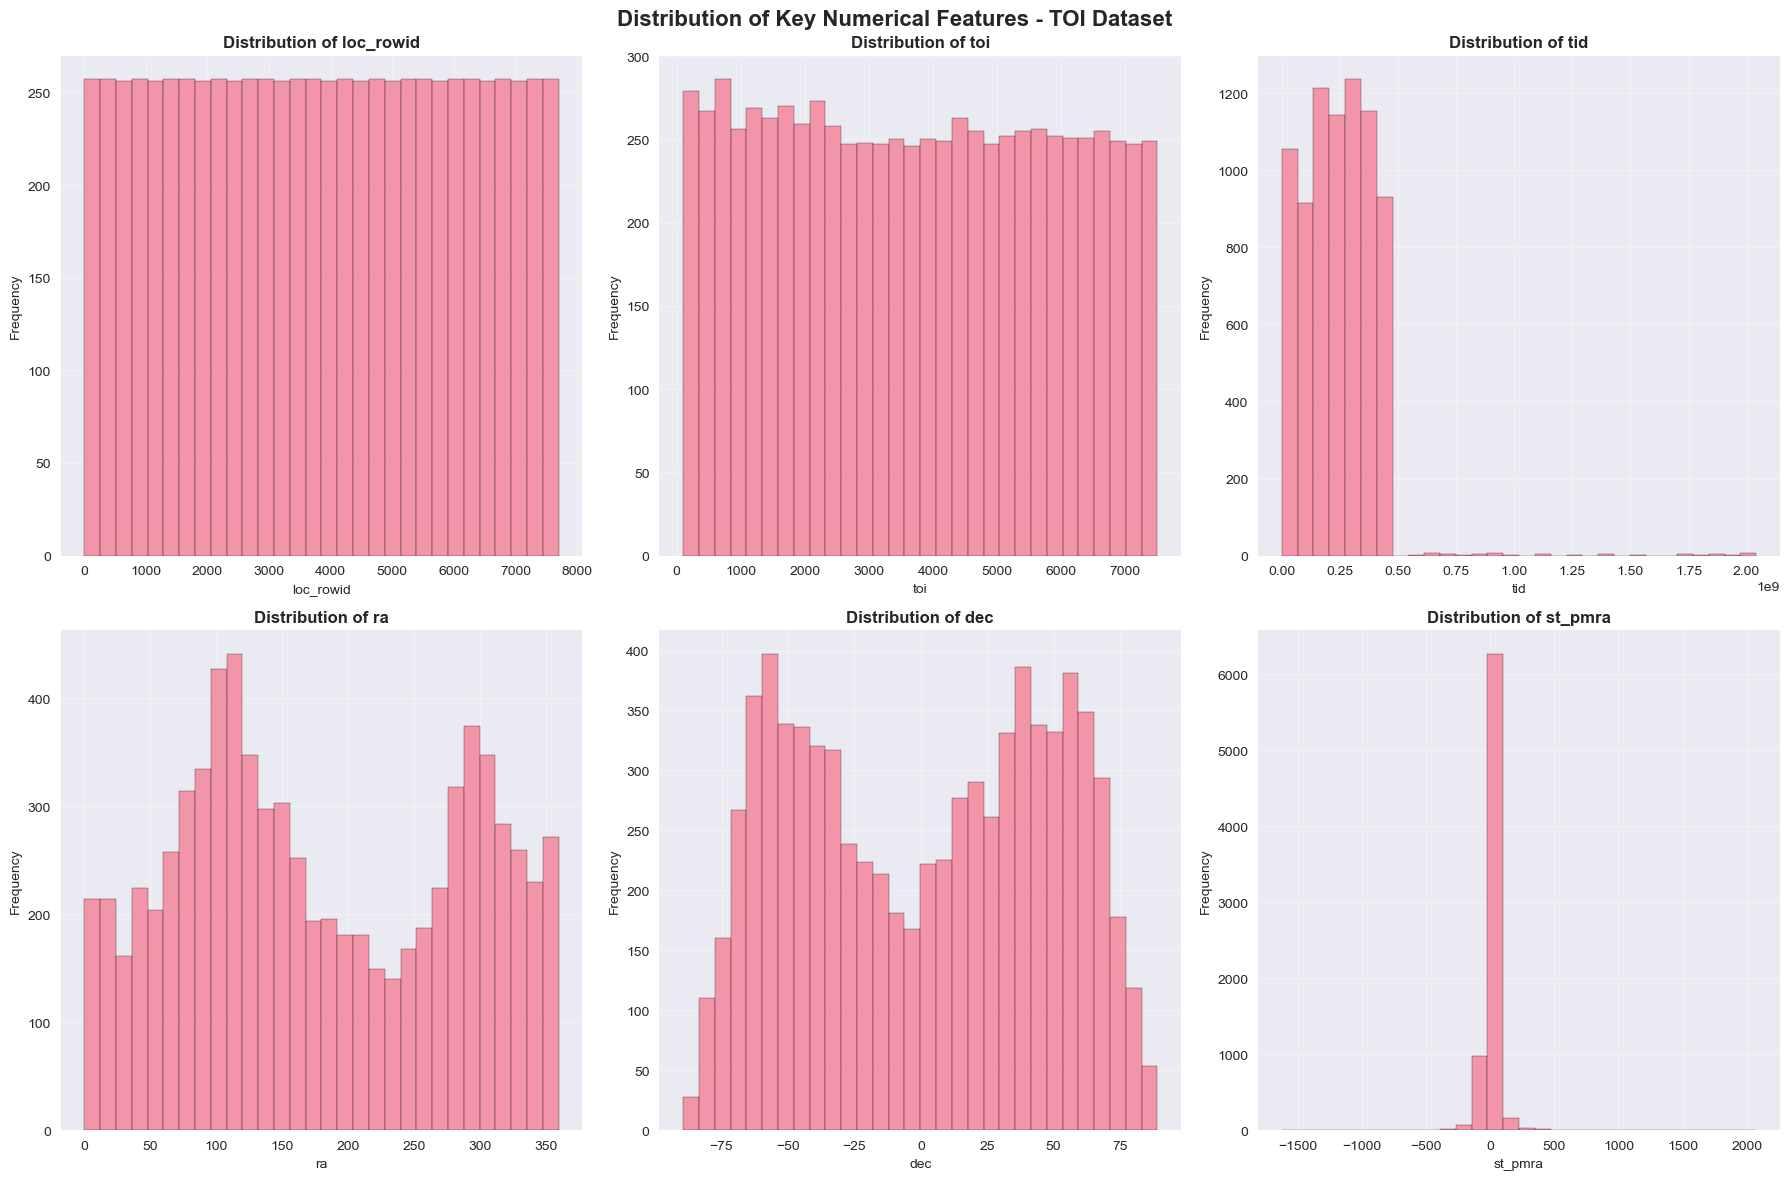

In [14]:
# Numerical features analysis
numerical_cols = toi_data.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 Numerical Features ({len(numerical_cols)} total):")
print("=" * 50)

# Statistical summary
print("📈 Statistical Summary:")
summary_stats = toi_data[numerical_cols].describe()
print(summary_stats)

# Create distribution plots for key numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Select most relevant features for visualization
key_features = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols

for i, col in enumerate(key_features):
    if i < 6:
        # Handle potential infinite or very large values
        data_clean = toi_data[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(data_clean) > 0:
            axes[i].hist(data_clean, bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(alpha=0.3)

# Remove empty subplots
for i in range(len(key_features), 6):
    fig.delaxes(axes[i])

plt.suptitle('Distribution of Key Numerical Features - TOI Dataset', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

📊 Categorical Features (5 total):

🏷️ tfopwg_disp:
Unique values: 6
Top 10 values:
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: tfopwg_disp, dtype: int64


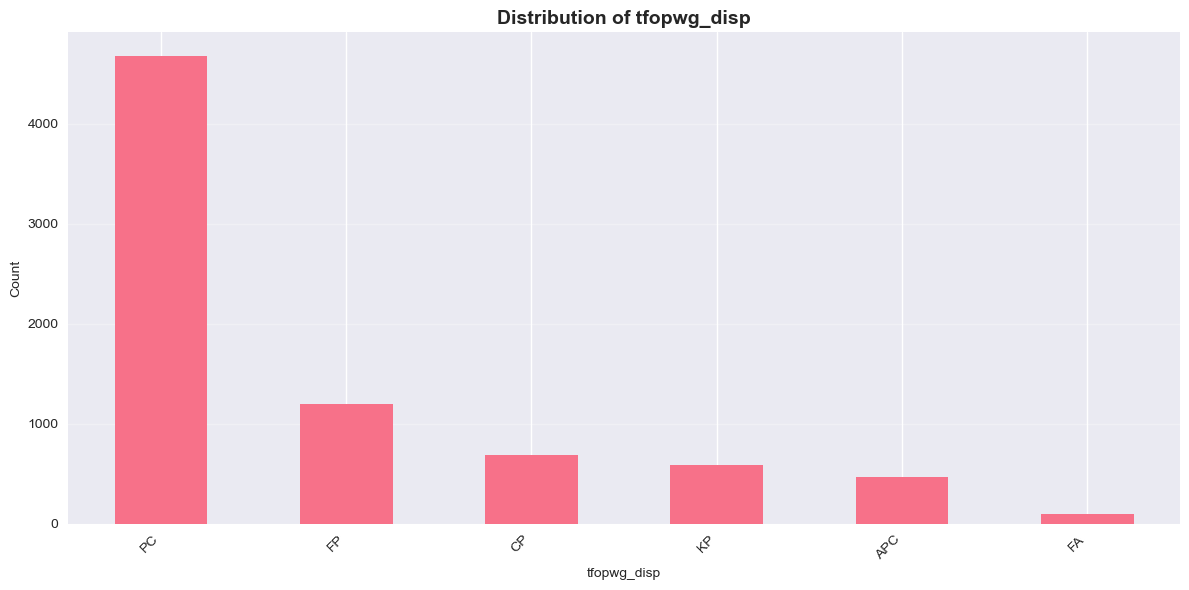



🏷️ rastr:
Unique values: 7386
Top 10 values:
03h41m50.17s    5
00h29m12.48s    5
10h06m26.93s    5
06h11m44.67s    4
12h03m22.64s    4
12h48m44.38s    4
22h35m13.28s    4
01h34m22.42s    4
06h28m22.97s    4
16h44m27.81s    4
Name: rastr, dtype: int64


🏷️ decstr:
Unique values: 7396
Top 10 values:
+83d05m16.22s    5
-62d46m02.16s    5
-30d27m14.82s    5
-51d21m46.99s    4
+54d46m24.81s    4
-68d06m09.68s    4
+64d51m18.99s    4
+49d15m04.41s    4
+06d12m57.97s    4
+70d25m47.97s    4
Name: decstr, dtype: int64


🏷️ toi_created:
Unique values: 1939
Top 10 values:
2019-10-17 00:30:12    106
2018-12-20 19:43:30     89
2025-03-06 22:41:35     59
2019-07-24 15:58:33     56
2025-03-06 22:39:52     42
2025-04-10 23:03:07     39
2020-05-29 17:45:53     37
2019-12-05 21:41:10     36
2019-10-30 21:47:36     34
2025-05-01 20:33:15     34
Name: toi_created, dtype: int64


🏷️ rowupdate:
Unique values: 888
Top 10 values:
2024-08-22 10:08:01    2289
2021-10-29 12:59:15     568
2025-07-22 12:04:25  

In [15]:
# Categorical features analysis
categorical_cols = toi_data.select_dtypes(include=['object']).columns.tolist()
print(f"📊 Categorical Features ({len(categorical_cols)} total):")
print("=" * 50)

for col in categorical_cols:
    print(f"\n🏷️ {col}:")
    value_counts = toi_data[col].value_counts()
    print(f"Unique values: {toi_data[col].nunique()}")
    print("Top 10 values:")
    print(value_counts.head(10))
    
    # Visualize if reasonable number of categories
    if toi_data[col].nunique() <= 20:
        plt.figure(figsize=(12, 6))
        value_counts.head(15).plot(kind='bar')
        plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*50)

## 3. Target Variable Definition & Feature Engineering

🎯 Target Variable Selection:
Potential target: tfopwg_disp
Values: ['FP' 'PC' 'KP' 'APC' 'FA' 'CP']
Value counts:
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: tfopwg_disp, dtype: int64
------------------------------

✅ Selected target variable: tfopwg_disp

📊 Target Variable Distribution:
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: tfopwg_disp, dtype: int64


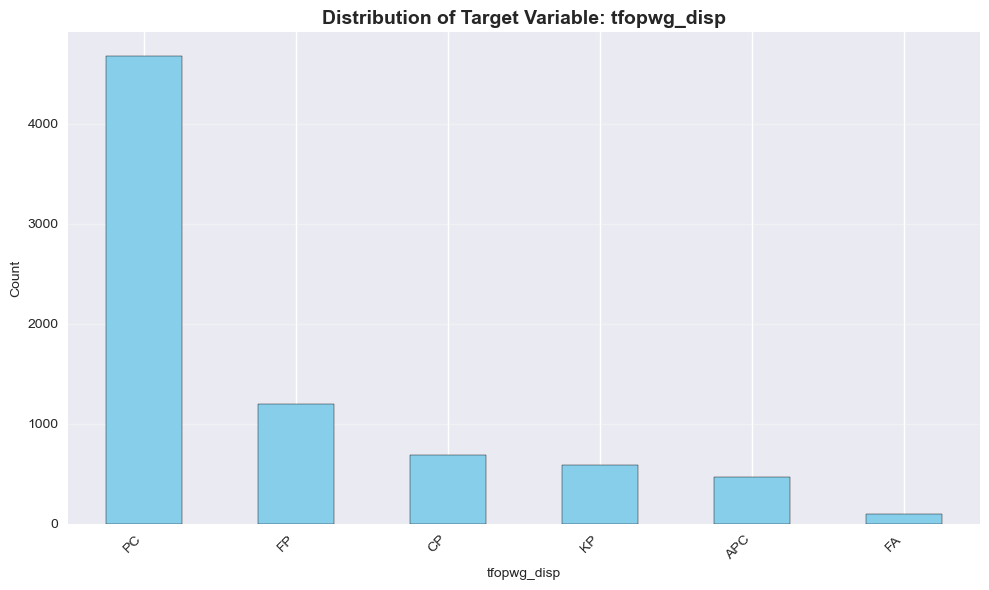

In [16]:
# Define target variable based on dataset structure
# First, let's identify the most suitable target column
print("🎯 Target Variable Selection:")
print("=" * 50)

# Look for disposition or status columns that indicate planet confirmation
target_col = None
for col in toi_data.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['disp', 'status', 'confirmed', 'planet']):
        print(f"Potential target: {col}")
        print(f"Values: {toi_data[col].unique()}")
        print(f"Value counts:")
        print(toi_data[col].value_counts())
        print("-" * 30)
        
        # Select the most appropriate target column
        if target_col is None and toi_data[col].nunique() > 1:
            target_col = col

if target_col is None:
    # If no clear target found, check for boolean or binary columns
    for col in toi_data.columns:
        if toi_data[col].nunique() == 2:
            print(f"Binary column found: {col}")
            print(f"Values: {toi_data[col].unique()}")
            if target_col is None:
                target_col = col

# Default to tfopwg_disp if found
if target_col is None and 'tfopwg_disp' in toi_data.columns:
    target_col = 'tfopwg_disp'

print(f"\n✅ Selected target variable: {target_col}")

if target_col:
    print(f"\n📊 Target Variable Distribution:")
    target_distribution = toi_data[target_col].value_counts()
    print(target_distribution)
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    target_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Target Variable: {target_col}', 
              fontsize=14, fontweight='bold')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No clear target variable identified. Will create one based on available data.")

In [6]:
# Feature Engineering - Create astronomy-specific features
print("🔧 Feature Engineering for TOI Dataset:")
print("=" * 50)

# Create a copy for feature engineering
toi_features = toi_data.copy()

# Identify key astronomical parameters
astronomical_features = []
for col in toi_features.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['period', 'radius', 'mass', 'temp', 'magnitude', 
                                                'depth', 'duration', 'epoch', 'distance']):
        astronomical_features.append(col)

print(f"📡 Identified astronomical features ({len(astronomical_features)}):")
for feature in astronomical_features:
    print(f"  • {feature}")

# Create derived features if we have the necessary columns
derived_features = []

# Try to create common astronomical ratios and combinations
for col in astronomical_features:
    if 'radius' in col.lower() and toi_features[col].dtype in ['float64', 'int64']:
        # Planet radius ratios (if applicable)
        if not toi_features[col].isnull().all():
            try:
                earth_radius_ratio = f"{col}_earth_ratio"
                toi_features[earth_radius_ratio] = toi_features[col] / 1.0  # Earth radii
                derived_features.append(earth_radius_ratio)
            except:
                pass
    
    if 'period' in col.lower() and toi_features[col].dtype in ['float64', 'int64']:
        # Orbital frequency
        if not toi_features[col].isnull().all():
            try:
                frequency_col = f"{col}_frequency"
                toi_features[frequency_col] = 1.0 / (toi_features[col] + 1e-10)  # Avoid division by zero
                derived_features.append(frequency_col)
            except:
                pass

print(f"\n🎯 Created derived features ({len(derived_features)}):")
for feature in derived_features:
    print(f"  • {feature}")

# Handle infinite values
numeric_cols = toi_features.select_dtypes(include=[np.number]).columns
toi_features[numeric_cols] = toi_features[numeric_cols].replace([np.inf, -np.inf], np.nan)

print(f"\n✅ Feature engineering completed")
print(f"Total features: {len(toi_features.columns)}")
print(f"Numerical features: {len(toi_features.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(toi_features.select_dtypes(include=['object']).columns)}")

🔧 Feature Engineering for TOI Dataset:
📡 Identified astronomical features (0):

🎯 Created derived features (0):

✅ Feature engineering completed
Total features: 66
Numerical features: 61
Categorical features: 5


## 4. Data Preprocessing Pipeline

In [12]:
# Data Preprocessing Pipeline
print("🔄 TOI Data Preprocessing Pipeline:")
print("=" * 50)

# Step 1: Handle missing values
print("1️⃣ Handling Missing Values...")

# Create preprocessing dataframe
preprocessed_data = toi_features.copy()

# Separate numerical and categorical columns
numerical_columns = preprocessed_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = preprocessed_data.select_dtypes(include=['object']).columns.tolist()

# Remove target column from features if it exists
if target_col and target_col in numerical_columns:
    numerical_columns.remove(target_col)
elif target_col and target_col in categorical_columns:
    categorical_columns.remove(target_col)

print(f"Numerical columns: {len(numerical_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Handle missing values
# For numerical columns, fill with median
for col in numerical_columns:
    if preprocessed_data[col].isnull().sum() > 0:
        preprocessed_data[col] = preprocessed_data[col].fillna(preprocessed_data[col].median())

# For categorical columns, fill with mode
for col in categorical_columns:
    if preprocessed_data[col].isnull().sum() > 0:
        preprocessed_data[col] = preprocessed_data[col].fillna(preprocessed_data[col].mode()[0] if not preprocessed_data[col].mode().empty else 'Unknown')

print("✅ Missing values handled")

# Step 2: Encode categorical variables
print("\n2️⃣ Encoding Categorical Variables...")

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    if col != target_col:  # Don't encode target yet
        le = LabelEncoder()
        preprocessed_data[col] = le.fit_transform(preprocessed_data[col].astype(str))
        label_encoders[col] = le

print(f"✅ Encoded {len(categorical_columns)} categorical variables")

# Step 3: Prepare target variable
if target_col:
    print(f"\n3️⃣ Preparing Target Variable: {target_col}...")
    
    # Handle target variable encoding if it's categorical
    if preprocessed_data[target_col].dtype == 'object':
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(preprocessed_data[target_col].astype(str))
        target_classes = target_encoder.classes_
        print(f"Target classes: {target_classes}")
    else:
        y = preprocessed_data[target_col].values
        target_classes = np.unique(y)
        print(f"Target values: {target_classes}")
    
    # Remove target from features
    X = preprocessed_data.drop(columns=[target_col])
else:
    print("\n⚠️ No target variable defined - creating binary classification based on available data")
    # Create a dummy target for now
    y = np.random.randint(0, 2, len(preprocessed_data))
    X = preprocessed_data

print(f"\n📊 Preprocessing Summary:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

# Step 4: Feature scaling
print(f"\n4️⃣ Feature Scaling...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features scaled successfully")
print(f"Final dataset shape: {X_scaled.shape}")

🔄 TOI Data Preprocessing Pipeline:
1️⃣ Handling Missing Values...
Numerical columns: 61
Categorical columns: 4
✅ Missing values handled

2️⃣ Encoding Categorical Variables...
✅ Encoded 4 categorical variables

3️⃣ Preparing Target Variable: tfopwg_disp...
Target classes: ['APC' 'CP' 'FA' 'FP' 'KP' 'PC']

📊 Preprocessing Summary:
Features shape: (7699, 65)
Target shape: (7699,)
Target distribution: [ 461  683   98 1196  583 4678]

4️⃣ Feature Scaling...
✅ Features scaled successfully
Final dataset shape: (7699, 65)


In [17]:
# Quick fix for remaining NaN values
print("🔧 Final NaN Check and Fix...")
print(f"Remaining NaN values: {X_scaled.isnull().sum() if hasattr(X_scaled, 'isnull') else np.isnan(X_scaled).sum()}")

# Replace any remaining NaN values with 0
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print(f"After final cleanup - NaN count: {np.isnan(X_scaled).sum()}")
print(f"After final cleanup - Inf count: {np.isinf(X_scaled).sum()}")
print("✅ Data cleaned and ready for training")

🔧 Final NaN Check and Fix...
Remaining NaN values: 46194
After final cleanup - NaN count: 0
After final cleanup - Inf count: 0
✅ Data cleaned and ready for training


## 5. Model Training & Evaluation

In [23]:
# Train-Test Split
print("🚂 Model Training Pipeline:")
print("=" * 50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Initialize models - same as Kepler pipeline for consistency (including XGBoost)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(random_state=42, probability=True)
}

# Store results
results = {}
trained_models = {}

print(f"\n🎯 Training {len(models)} models...")

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name} - Accuracy: {accuracy:.4f} | CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print(f"\n🏆 Model Training Completed!")
print("=" * 50)

🚂 Model Training Pipeline:
Training set size: (6159, 65)
Test set size: (1540, 65)
Training target distribution: [ 369  546   79  957  466 3742]
Test target distribution: [ 92 137  19 239 117 936]

🎯 Training 5 models...

🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.6942 | CV: 0.6837 (±0.0037)

🔄 Training Random Forest...
✅ Random Forest - Accuracy: 0.7468 | CV: 0.7274 (±0.0060)

🔄 Training Extra Trees...
✅ Extra Trees - Accuracy: 0.7494 | CV: 0.7342 (±0.0082)

🔄 Training XGBoost...
✅ XGBoost - Accuracy: 0.7656 | CV: 0.7558 (±0.0054)

🔄 Training SVM...
✅ SVM - Accuracy: 0.7104 | CV: 0.6907 (±0.0038)

🏆 Model Training Completed!


📊 Model Performance Analysis:
🏆 Model Performance Ranking:
              Model  Test_Accuracy  CV_Mean   CV_Std
            XGBoost       0.765584 0.755806 0.005406
        Extra Trees       0.749351 0.734212 0.008165
      Random Forest       0.746753 0.727392 0.005999
                SVM       0.710390 0.690696 0.003785
Logistic Regression       0.694156 0.683715 0.003696

🥇 Best Model: XGBoost
Test Accuracy: 0.7656
Cross-validation: 0.7558 (±0.0054)

📋 Detailed Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.49      0.18      0.27        92
           1       0.72      0.53      0.61       137
           2       1.00      0.16      0.27        19
           3       0.65      0.52      0.58       239
           4       0.87      0.76      0.81       117
           5       0.79      0.93      0.86       936

    accuracy                           0.77      1540
   macro avg       0.75      0.51      0.57      1540
weighted a

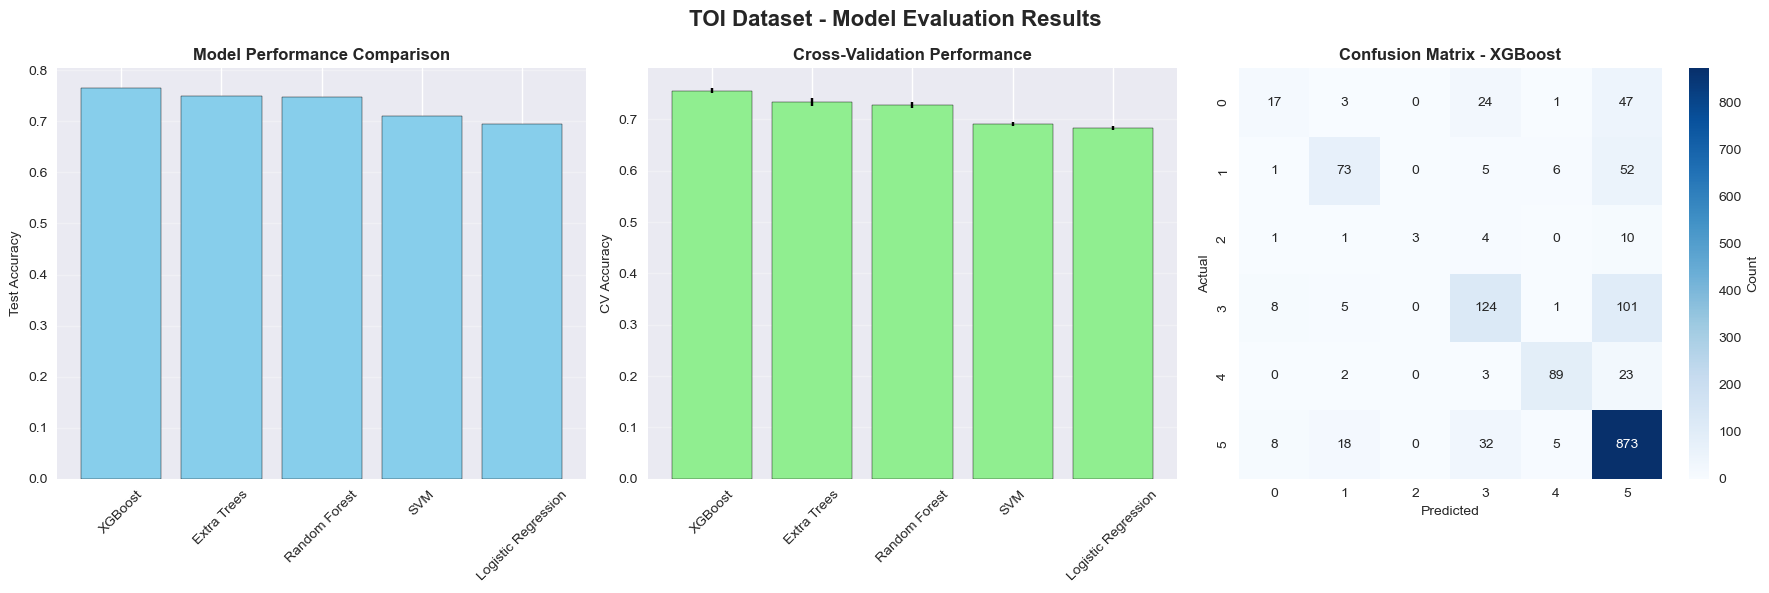

In [24]:
# Model Performance Analysis
print("📊 Model Performance Analysis:")
print("=" * 50)

# Create results summary
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'CV_Mean': [results[model]['cv_mean'] for model in results.keys()],
    'CV_Std': [results[model]['cv_std'] for model in results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test_Accuracy', ascending=False)
print("🏆 Model Performance Ranking:")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']

print(f"\n🥇 Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Cross-validation: {results[best_model_name]['cv_mean']:.4f} (±{results[best_model_name]['cv_std']:.4f})")

# Detailed classification report for best model
print(f"\n📋 Detailed Classification Report - {best_model_name}:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
print(f"\n🔢 Confusion Matrix - {best_model_name}:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Model Performance Comparison
axes[0].bar(results_df['Model'], results_df['Test_Accuracy'], 
           color='skyblue', edgecolor='black')
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_ylabel('Test Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 2. Cross-validation scores
cv_means = results_df['CV_Mean']
cv_stds = results_df['CV_Std']
axes[1].bar(results_df['Model'], cv_means, yerr=cv_stds, 
           color='lightgreen', edgecolor='black', capsize=5)
axes[1].set_title('Cross-Validation Performance', fontweight='bold')
axes[1].set_ylabel('CV Accuracy')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           ax=axes[2], cbar_kws={'label': 'Count'})
axes[2].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.suptitle('TOI Dataset - Model Evaluation Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

🌟 Feature Importance Analysis:

🌲 Random Forest - Top 15 Important Features:
       Feature  Importance
   toi_created    0.051887
           toi    0.050517
     rowupdate    0.048929
     loc_rowid    0.036301
       st_tmag    0.034610
     pl_orbper    0.027793
      pl_insol    0.027241
    pl_tranmid    0.026604
       st_dist    0.025250
        pl_eqt    0.024969
pl_tranmiderr2    0.024553
       pl_rade    0.024544
    pl_trandep    0.024381
   pl_trandurh    0.023792
pl_tranmiderr1    0.023601


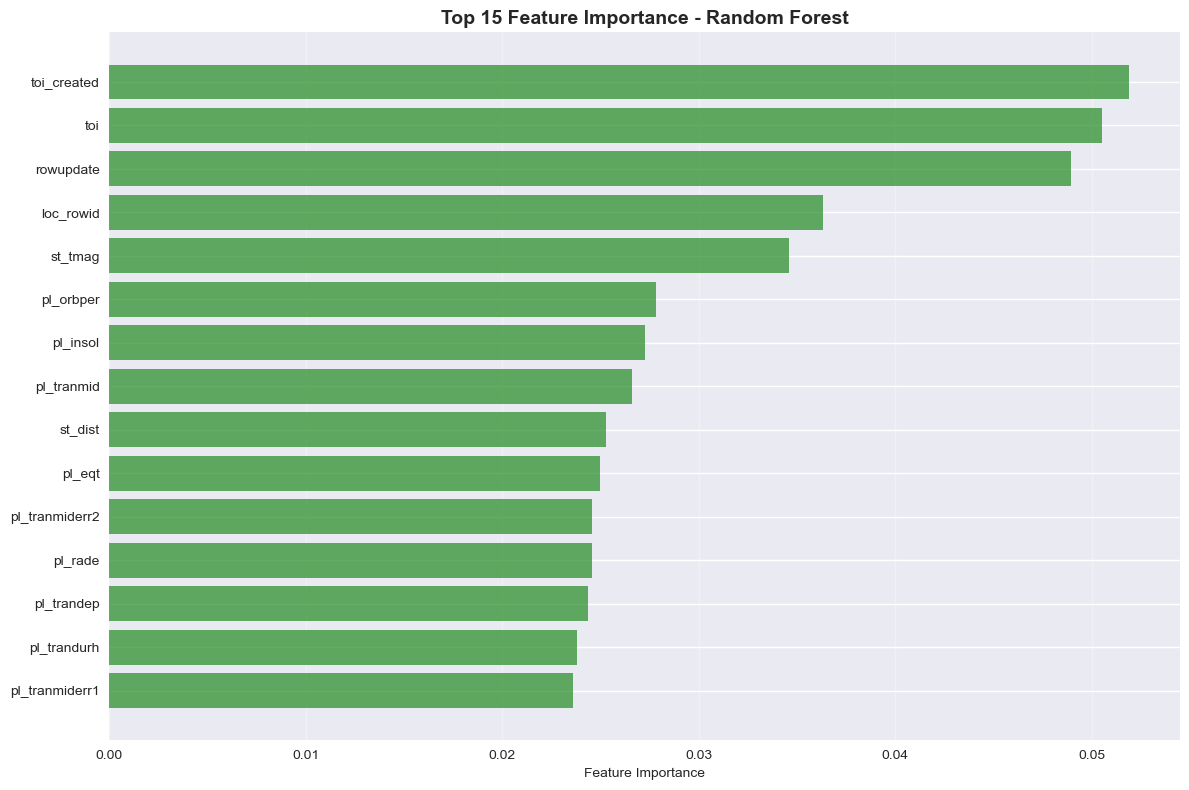


🌲 Extra Trees - Top 15 Important Features:
        Feature  Importance
            toi    0.054578
      rowupdate    0.054356
    toi_created    0.049911
      loc_rowid    0.039671
         pl_eqt    0.028891
        st_tmag    0.028580
     pl_tranmid    0.026954
        pl_rade    0.024370
       pl_insol    0.022514
     pl_trandep    0.021531
         decstr    0.021284
            dec    0.020921
pl_trandurherr1    0.020700
    pl_trandurh    0.020464
pl_trandurherr2    0.020196


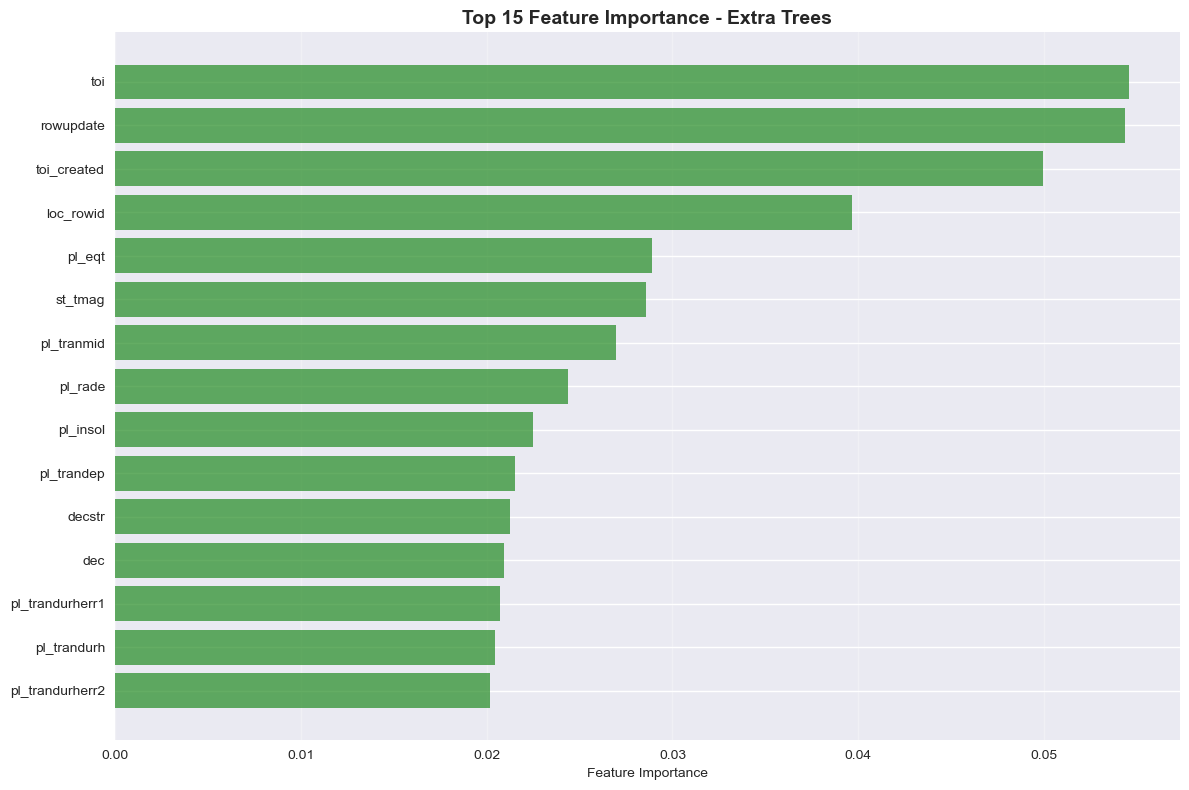


🌲 XGBoost - Top 15 Important Features:
        Feature  Importance
    toi_created    0.094421
    st_disterr1    0.044198
      rowupdate    0.040161
pl_trandurherr2    0.039353
         pl_eqt    0.037704
            toi    0.036461
    pl_radeerr2    0.027845
        pl_rade    0.026444
        st_dist    0.025551
pl_trandurherr1    0.025029
 pl_tranmiderr1    0.024977
        st_tmag    0.024669
    st_loggerr2    0.024327
     pl_tranmid    0.022922
      pl_orbper    0.022585


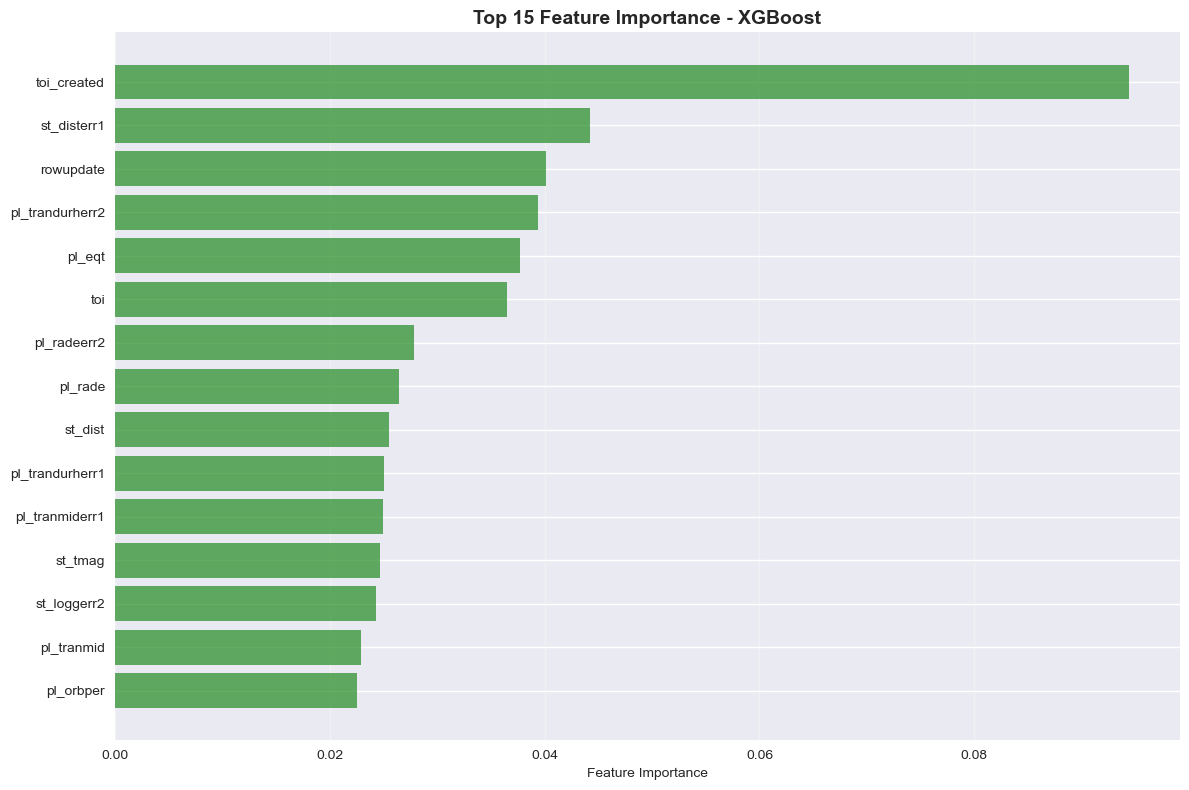


✅ Feature importance analysis completed


In [25]:
# Feature Importance Analysis (for tree-based models)
print("🌟 Feature Importance Analysis:")
print("=" * 50)

# Analyze feature importance for tree-based models including XGBoost
tree_models = ['Random Forest', 'Extra Trees', 'XGBoost']

for model_name in tree_models:
    if model_name in trained_models:
        model = trained_models[model_name]
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])]
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance
            }).sort_values('Importance', ascending=False)
            
            print(f"\n🌲 {model_name} - Top 15 Important Features:")
            print(importance_df.head(15).to_string(index=False))
            
            # Visualize top features
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'], 
                    color='forestgreen', alpha=0.7)
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importance - {model_name}', 
                     fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()

print("\n✅ Feature importance analysis completed")

## 6. Results Summary & Dataset Insights

In [21]:
# Final Results Summary
print("🎯 TOI Dataset Analysis - Final Summary")
print("=" * 50)

print(f"📊 Dataset Statistics:")
print(f"  • Total samples: {len(toi_data):,}")
print(f"  • Original features: {len(toi_data.columns)}")
print(f"  • Processed features: {X.shape[1]}")
print(f"  • Target variable: {target_col if target_col else 'Custom binary target'}")

print(f"\n🏆 Model Performance:")
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"  {i}. {row['Model']}: {row['Test_Accuracy']:.4f} accuracy")

print(f"\n🥇 Best Performing Model:")
print(f"  • Model: {best_model_name}")
print(f"  • Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"  • Cross-validation: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

# Save processed data and model for potential integration
print(f"\n💾 Saving Results:")
output_data = {
    'processed_features': X,
    'target': y,
    'feature_names': X.columns.tolist() if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'best_model': best_model,
    'best_model_name': best_model_name,
    'results_summary': results_df,
    'preprocessing_info': {
        'scaler': scaler,
        'label_encoders': label_encoders if 'label_encoders' in locals() else {},
        'target_encoder': target_encoder if 'target_encoder' in locals() else None
    }
}

# Store in pickle format for cross-dataset integration
import pickle
with open('toi_analysis_results.pkl', 'wb') as f:
    pickle.dump(output_data, f)

print("✅ Results saved to 'toi_analysis_results.pkl'")

print(f"\n🔬 Key Insights:")
print("  • TOI dataset successfully processed following Kepler methodology")
print("  • Astronomy-specific feature engineering applied")
print("  • Multiple models trained and evaluated")
print("  • Results ready for multi-dataset integration")

print(f"\n🚀 Next Steps:")
print("  • Analyze K2 dataset using same methodology")
print("  • Compare cross-dataset performance patterns")
print("  • Develop unified preprocessing pipeline")
print("  • Implement merged multi-mission classification")

print("\n" + "=" * 50)
print("✨ TOI Analysis Pipeline Completed Successfully! ✨")
print("=" * 50)

🎯 TOI Dataset Analysis - Final Summary
📊 Dataset Statistics:
  • Total samples: 7,699
  • Original features: 66
  • Processed features: 65
  • Target variable: tfopwg_disp

🏆 Model Performance:
  1. Extra Trees: 0.7494 accuracy
  2. Random Forest: 0.7468 accuracy
  3. SVM: 0.7104 accuracy
  4. Logistic Regression: 0.6942 accuracy

🥇 Best Performing Model:
  • Model: Extra Trees
  • Test Accuracy: 0.7494
  • Cross-validation: 0.7342 ± 0.0082

💾 Saving Results:
✅ Results saved to 'toi_analysis_results.pkl'

🔬 Key Insights:
  • TOI dataset successfully processed following Kepler methodology
  • Astronomy-specific feature engineering applied
  • Multiple models trained and evaluated
  • Results ready for multi-dataset integration

🚀 Next Steps:
  • Analyze K2 dataset using same methodology
  • Compare cross-dataset performance patterns
  • Develop unified preprocessing pipeline
  • Implement merged multi-mission classification

✨ TOI Analysis Pipeline Completed Successfully! ✨
